# Haba Obstgarten

* [Erste Analysen](#Erste-Analysen)
* [Simulation](#Simulation)
* [Ergebnisse](#Ergebnisse)

# Hintergrund

Hintergrund zu dem Spiel Obstgarten findet sich in meinem [Blog](http://datenspieler.com/Haba-Obstgarten/)

### Erste Analysen
Die Liste `wuerfel` beschreibt die jeweiligen Seiten des Würfels. Mittels `random.choice(wuerfel)`, wird dann eine zufällige Aktion "erwürfelt".

In [1]:
wuerfel = ('apfel', 'birne', 'kirsche', 'zwetschke', 'korb', 'rabe')

In [2]:
import random
aktion = random.choice(wuerfel)
aktion

'kirsche'

Im Python Dictionary `status` wird der Zustand des Spiels beschreiben, sprich wie viele Früchte noch auf den Bäumen sind und wie viele Rabenteile schon aufgelegt sind. Damit lässt sich dann einmal Würfeln und die Auswirkung davon, ausgenommen `Korb`, dazu komme ich gleich, leicht abbilden. Das `max(..., 0)` beim Update des Status dient dazu, dass nicht negative Zahlen entstehen, falls ein Obst gewürfelt wird, dass gar nicht auf einem Baum hängt.

In [3]:
status = {'apfel': 10, 'birne': 10, 'kirsche': 10, 'zwetschke': 10, 'rabe': 0}

In [4]:
aktion = random.choice(wuerfel)
print('Aktion:', aktion)
if aktion in ('apfel', 'birne', 'kirsche', 'zwetschke'):
    status[aktion] = max(status[aktion] - 1, 0)
elif aktion == 'rabe':
    status[aktion] += 1
print('Stats:', status)

Aktion: birne
Stats: {'rabe': 0, 'apfel': 10, 'zwetschke': 10, 'kirsche': 10, 'birne': 9}


Jetzt kommen wir zum spannenden Teil - der Korb-Seite des Würfels. Dass der Korb wichtig ist, zeigt folgende Überlegung. Angenommen, es gebe den Korb nicht: um den Raben fertig zu bauen, benötigt man 9 Teile, vom Obst gibt es 10 Teile. Somit wäre der Rabe im Schnitt also schneller zusammengebaut, als jedes einzelne Obst für sich genommen abgeerntet wäre. Bei 4 Obstsorten wäre der Rabe dann ganz klar im Vorteil und die Spieler würden fast immer verlieren. 

Aber zum Glück gibt es den Korb, der das Spiel zugunsten der Spieler beeinflusst. Zusätzlich ist der Korb der einzige Teil des Spiels, bei dem der Spieler eine Entscheidung treffen kann und muss: welches Obst soll geerntet werden? Die offensichtig optimale Strategie ist es, die Bäume abzuerntet, an denen noch die meisten Früchte hängen. Das kommt daher, dass der Würfel kein Gedächtnis hat, sprich bei den folgenden Würfen im Durchschnitt die 4 Obstsorten gleich häufig gewürfelt werden. Auch, wenn bei den vergangen Würfen die eine oder andere Sorte öfters gewürfelt wurde.

Technisch erfolgt die Umsetzung via der `max` Funktion, der man via des Schlüsselworts `key` die Funktion `get` mitgeben kann. Damit wird das Maximum über die Werte des Dictionary `status` ermittelt. `max(status)` würde das alphabetisch "größte" Obst (=Zwetschke) liefern.

In [5]:
status['birne']

9

In [6]:
status.get('birne')

9

In [7]:
max(status, key=status.get)

'apfel'

In [8]:
print('Status:', status)
aktion = max(status, key=status.get)
print('Aktion:', aktion)
status[aktion] = max(status[aktion] - 1, 0)
print('Status:', status)

Status: {'rabe': 0, 'apfel': 10, 'zwetschke': 10, 'kirsche': 10, 'birne': 9}
Aktion: apfel
Status: {'rabe': 0, 'apfel': 9, 'zwetschke': 10, 'kirsche': 10, 'birne': 9}


Aber nicht jeder Spieler folgt der optimalten Strategie. Ich habe zwei zusätzliche Strategien implementiert: einerseits eine Zufallsstrategie - hier wird einfach zufällig ein Obst geerntet, andererseits die schlechteste Strategie - man erntet immer das Obst, von dem es bereits am wenigsten gibt. In der Analyse wird sich dann die Auswirkung der Strategiewahl zeigen.

Bei der technischen Umsetzung ist zu beachten, dass zuerst die Obstsorten, bei denen es gar keine Früchte mehr am Baum gibt, ausgeschlossen werden. Dazu lagere ich diese Obstsorten, zusammen mit dem Wert für den Raben temporär in andere Dictionaries aus.

In [9]:
status = {'apfel': 3, 'birne': 0, 'kirsche': 1, 'zwetschke': 4, 'rabe': 2}

In [10]:
print('Status:', status)

status_sicherung = {k:v for k,v in status.items() if (v == 0) | (k=='rabe')}
status_zu_ernten = {k:v for k,v in status.items() if (v > 0) & (k!='rabe')}    
 
print('Status zu ernten:', status_zu_ernten)
aktion = min(status_zu_ernten, key=status_zu_ernten.get)
print('Aktion:', aktion)
status_zu_ernten[aktion] = max(status_zu_ernten[aktion] - 1, 0)
print('Status zu ernten:', status_zu_ernten)

status = {**status_sicherung, **status_zu_ernten}
print('Status:', status)

Status: {'rabe': 2, 'apfel': 3, 'zwetschke': 4, 'kirsche': 1, 'birne': 0}
Status zu ernten: {'apfel': 3, 'zwetschke': 4, 'kirsche': 1}
Aktion: kirsche
Status zu ernten: {'apfel': 3, 'zwetschke': 4, 'kirsche': 0}
Status: {'rabe': 2, 'apfel': 3, 'zwetschke': 4, 'kirsche': 0, 'birne': 0}


### Simulation 

Für eine Simulation müssen die obrigen Schritte nur mehr richtig in Funktionen verpackt werden und dann öfters ausgeführt werden. Konkret werden die folgenden Funktionen definiert:
- `korb(status, strategie_max, strategie_min, strategie_random, detail_zuege=True, erster_durchlauf=True, strategie_zweiter_durchlauf=0)`: basierend auf der übergebenen Strategie wird die Aktivität Korb durchgeführt. `status` ist der aktuelle Status, sprich wieviele  Früchte sind auf welchen Bäumen. 
    - Die Variablen `strategie_max, strategie_min, strategie_random` geben jeweils an, wieviele Spieler (absolut oder prozentuell, funktioniert beides) die jeweilige Strategie verfolgen, d.h., entweder ein Obst vom Baum mit den meisten Früchten ernten, mit den wenigsten oder zufällig. 
    - `detail_zuege` gibt an, ob eine explizite Ausgabe erfolgen soll, welche Frucht ausgewählt wurde. 
    - Da bei Korb zwei Früchte geerntet werden, ruft sich die Funktion `korb` beim ersten Durchlauf, erkennbar an `erster_durchlauf` ein zweites Mal selber auf. Dabei wird mittels `strategie_zweiter_durchlauf` die konkrete Strategie mitgegeben. Die Annahme ist hier, dass die Strategie des Spielers für die erste Frucht gleich ist wie für die zweite Frucht und nicht nochmal zufällig ermittelt wird. 
    - In der Funktion werden zuerst der Rabe und die bereits abgeernteten Bäume entfernt, dann wird die Strategie festgelegt, basierend auf der Strategie eine (die Funktion muss also zweimal aufgerufen werden, da bei Korb ja zwei Früchte geerntet werden dürfen) Frucht abgeerntet und zuletzt Rabe sowie leere Bäume wieder hinzugefügt. Der aktualisierte `status` wird von der Funktion zurückgegeben.
    
- `spielen(zuege = 0, letz_status = False, strategie_max=1, strategie_min=0, strategie_random=0, status = {'apfel': 10, 'birne': 10, 'kirsche': 10, 'zwetschke': 10, 'rabe': 0})`: hier wird ein Spiel durchgeführt. 
    -`zuege`gibt an, ob die Zwischenschritte ausgegeben werden sollen (0 - keine Ausgabe, 1 - Ausgabe Einzelzüge, 2 - Ausgabe Einzelzüge und Details bzgl. Korb), 
    - `letzt_status` gibt an, ob das Ergebnis auch als Text ausgegeben werden soll, 
    - `strategie_max`, `strategie_min` und `strategie_random` bestimmen wie bei der Funktion `korb` beschrieben die Strategie bzgl. der Aktivität Korb. 
    - Mittels des Dictionaries `status` hat man die Möglichkeit alternative Ausgangssituationen zu übergeben, z.B. nur 8 Äpfel. 
    - Die Funktion gibt ein Dictionary mit den Ergebnissen zurück, konkret `gewonnen` (True oder False), `gespielte_runden` (Anzahl gespielter Runden), `raben_teile` (Anzahl ausgelegter Rabenteile, 9 falls der Rabe gewonnen hat), `fruechte` (Anzahl der Früchte, die noch nicht geerntet wurden) und `strategie_max_min_rand` (Information bzgl. der Strategie)

- `simulation(anzahl, strategie_max=1, strategie_min=0, strategie_random=0)` : Simulation von `anzahl` Spielen. Zurückgegeben wird ein Dataframe,der pro Spiel die oben beschriebene Information (`gewonnen`,`gespielte_runden`, `raben_teile`, `fruechte`, `strategie_max_min_rand`) enthält.

In [11]:
import pandas as pd

def korb(status, strategie_max, strategie_min, strategie_random, detail_zuege=True, 
         erster_durchlauf=True, strategie_zweiter_durchlauf=0):
    #rabe Fruechte mit Anzahl 0 entfernen in getrenntem dicstionary speichern
    status_sicherung = {k:v for k,v in status.items() if (v == 0) | (k=='rabe')}
    status_zu_ernten = {k:v for k,v in status.items() if (v > 0) & (k!='rabe')}    
    
    #Check ob noch Fruechte am Baum
    if len(status_zu_ernten) > 0:

        #Strategie bestimmen
        if erster_durchlauf:
            zufall_strategie = random.random() * (strategie_max + strategie_min + strategie_random)
            strategie_zweiter_durchlauf = zufall_strategie
        else:
            zufall_strategie = strategie_zweiter_durchlauf

        if zufall_strategie < strategie_max:
            aktion = max(status_zu_ernten, key=status_zu_ernten.get)
            status_zu_ernten[aktion] = max(0, status_zu_ernten[aktion] - 1)
            if detail_zuege:
                print('.korb-max {:<12}:'.format(aktion),status_zu_ernten)

        elif zufall_strategie < strategie_max + strategie_min:
            aktion = min(status_zu_ernten, key=status_zu_ernten.get)
            status_zu_ernten[aktion] = max(0, status_zu_ernten[aktion] - 1)
            if detail_zuege:
                print('.korb-min {:<12}:'.format(aktion),status_zu_ernten)
        else:
            aktion = random.choice(list(status_zu_ernten.keys()))
            status_zu_ernten[aktion] = max(0, status_zu_ernten[aktion] - 1)
            if detail_zuege:
                print('.korb-rnd {:<12}:'.format(aktion),status_zu_ernten)    
            
    # Fruechte mit Anzahl 0 und rabe wieder zu status zusammenfügen
    # only works in Python 3.5 onwards
    # status = {**status_sicherung, **status_zu_ernten}
    
    status = status_sicherung.copy()
    status.update(status_zu_ernten)
    
    if erster_durchlauf:
        status = korb(status, strategie_max, strategie_min, strategie_random, detail_zuege, 
                      erster_durchlauf=False, strategie_zweiter_durchlauf=strategie_zweiter_durchlauf)    
    return status

def spielen(zuege = 0, letzt_status = False, strategie_max=1, strategie_min=0, strategie_random=0,
           status = {'apfel': 10, 'birne': 10, 'kirsche': 10, 'zwetschke': 10, 'rabe': 0}):
# zuege = 0 - keine ausgabe einzelner Zuege
# zuege = 1 - Ausgabe einzelner Zuege
# zuege = 2 - Ausgabe einzelner Zuege + Detailzuege bzgl. Korb
    status = {'apfel': 10, 'birne': 10, 'kirsche': 10, 'zwetschke': 10, 'rabe': 0}
    runden = 0
    
    while ((status['apfel'] > 0) or (status['birne'] > 0) or (status['kirsche'] > 0) or (status['zwetschke'] > 0)) \
        and (status['rabe'] < 9): 

        aktion = random.choice(wuerfel)
 
        if aktion in ('apfel', 'birne', 'kirsche', 'zwetschke'):
            status[aktion] = max(status[aktion] - 1, 0)
        elif aktion == 'rabe':
            status[aktion] += 1
        else:        
            status = korb(status, strategie_max, strategie_min, strategie_random,
                         detail_zuege = max(0, zuege - 1))
    
        if zuege:
            print('{:<22}:'.format(aktion),status)
                        
        runden += 1
            
    if status['rabe'] == 9:
        if letzt_status:
            print('{:<22}:'.format('Verloren'),status)
            print('Verloren, der Rabe ist fertig.')
        return {'gewonnen': False, 'gespielte_runden': runden, 
                'raben_teile': status['rabe'], 'fruechte': sum(status[d] for d in status if d != 'rabe'),
                'strategie_max_min_rand': (strategie_max, strategie_min, strategie_random)}
    else:
        if letzt_status:
            print('{:<22}:'.format('Gewonnen'),status)
            print('Gewonnen, alle Bäume abgeerntet.')
        return {'gewonnen': True, 'gespielte_runden': runden, 
                'raben_teile': status['rabe'], 'fruechte': sum(status[d] for d in status if d != 'rabe'),
                'strategie_max_min_rand': (strategie_max, strategie_min, strategie_random)}
    
def simulation(anzahl, strategie_max=1, strategie_min=0, strategie_random=0):
    df = pd.DataFrame()
    for i in range(anzahl):
        df = df.append(pd.DataFrame([spielen(strategie_max=strategie_max,
                                             strategie_min=strategie_min, 
                                             strategie_random=strategie_random)]))
    return df

In [12]:
import pandas as pd

def korb(status, strategie_max, strategie_min, strategie_random, detail_zuege=True, 
         erster_durchlauf=True, strategie_zweiter_durchlauf=0):
    #rabe Fruechte mit Anzahl 0 entfernen in getrenntem dicstionary speichern
    status_sicherung = {k:v for k,v in status.items() if (v == 0) | (k=='rabe')}
    status_zu_ernten = {k:v for k,v in status.items() if (v > 0) & (k!='rabe')}    
    
    #Check ob noch Fruechte am Baum
    if len(status_zu_ernten) > 0:

        #Strategie bestimmen
        if erster_durchlauf:
            zufall_strategie = random.random() * (strategie_max + strategie_min + strategie_random)
            strategie_zweiter_durchlauf = zufall_strategie
        else:
            zufall_strategie = strategie_zweiter_durchlauf

        if zufall_strategie < strategie_max:
            aktion = max(status_zu_ernten, key=status_zu_ernten.get)
            status_zu_ernten[aktion] = max(0, status_zu_ernten[aktion] - 1)
            if detail_zuege:
                print('.korb-max {:<12}:'.format(aktion),status_zu_ernten)

        elif zufall_strategie < strategie_max + strategie_min:
            aktion = min(status_zu_ernten, key=status_zu_ernten.get)
            status_zu_ernten[aktion] = max(0, status_zu_ernten[aktion] - 1)
            if detail_zuege:
                print('.korb-min {:<12}:'.format(aktion),status_zu_ernten)
        else:
            aktion = random.choice(list(status_zu_ernten.keys()))
            status_zu_ernten[aktion] = max(0, status_zu_ernten[aktion] - 1)
            if detail_zuege:
                print('.korb-rnd {:<12}:'.format(aktion),status_zu_ernten)    
            
    # Fruechte mit Anzahl 0 und rabe wieder zu status zusammenfügen
    # only works in Python 3.5 onwards
    # status = {**status_sicherung, **status_zu_ernten}
    
    status = status_sicherung.copy()
    status.update(status_zu_ernten)
    
    if erster_durchlauf:
        status = korb(status, strategie_max, strategie_min, strategie_random, detail_zuege, 
                      erster_durchlauf=False, strategie_zweiter_durchlauf=strategie_zweiter_durchlauf)    
    return status

def spielen(zuege = 0, letzt_status = False, strategie_max=1, strategie_min=0, strategie_random=0,
           status = {'apfel': 10, 'birne': 10, 'kirsche': 10, 'zwetschke': 10, 'rabe': 0}):
# zuege = 0 - keine ausgabe einzelner Zuege
# zuege = 1 - Ausgabe einzelner Zuege
# zuege = 2 - Ausgabe einzelner Zuege + Detailzuege bzgl. Korb
    status = {'apfel': 10, 'birne': 10, 'kirsche': 10, 'zwetschke': 10, 'rabe': 0}
    runden = 0
    
    while ((status['apfel'] > 0) or (status['birne'] > 0) or (status['kirsche'] > 0) or (status['zwetschke'] > 0)) \
        and (status['rabe'] < 9): 

        aktion = random.choice(wuerfel)
 
        if aktion in ('apfel', 'birne', 'kirsche', 'zwetschke'):
            status[aktion] = max(status[aktion] - 1, 0)
        elif aktion == 'rabe':
            status[aktion] += 1
        else:        
            status = korb(status, strategie_max, strategie_min, strategie_random,
                         detail_zuege = max(0, zuege - 1))
    
        if zuege:
            print('{:<22}:'.format(aktion),status)
                        
        runden += 1
            
    if status['rabe'] == 9:
        if letzt_status:
            print('{:<22}:'.format('Verloren'),status)
            print('Verloren, der Rabe ist fertig.')
        return {'gewonnen': False, 'gespielte_runden': runden, 
                'raben_teile': status['rabe'], 'fruechte': sum(status[d] for d in status if d != 'rabe'),
                'strategie_max': strategie_max,
                'strategie_min': strategie_min,
                'strategie_rnd': strategie_random}
    else:
        if letzt_status:
            print('{:<22}:'.format('Gewonnen'),status)
            print('Gewonnen, alle Bäume abgeerntet.')
        return {'gewonnen': True, 'gespielte_runden': runden, 
                'raben_teile': status['rabe'], 'fruechte': sum(status[d] for d in status if d != 'rabe'),
                'strategie_max': strategie_max,
                'strategie_min': strategie_min,
                'strategie_rnd': strategie_random}
    
def simulation(anzahl, strategie_max=1, strategie_min=0, strategie_random=0):
    df = pd.DataFrame()
    for i in range(anzahl):
        df = df.append(pd.DataFrame([spielen(strategie_max=strategie_max,
                                             strategie_min=strategie_min, 
                                             strategie_random=strategie_random)]))
    return df

In [13]:
spielen()

{'fruechte': 8,
 'gespielte_runden': 33,
 'gewonnen': False,
 'raben_teile': 9,
 'strategie_max': 1,
 'strategie_min': 0,
 'strategie_rnd': 0}

In [14]:
spielen(zuege=2, letzt_status=True, strategie_max=2, strategie_min=1, strategie_random=2)

birne                 : {'rabe': 0, 'apfel': 10, 'zwetschke': 10, 'kirsche': 10, 'birne': 9}
zwetschke             : {'rabe': 0, 'apfel': 10, 'zwetschke': 9, 'kirsche': 10, 'birne': 9}
.korb-rnd zwetschke   : {'apfel': 10, 'zwetschke': 8, 'kirsche': 10, 'birne': 9}
.korb-rnd birne       : {'apfel': 10, 'zwetschke': 8, 'kirsche': 10, 'birne': 8}
korb                  : {'rabe': 0, 'apfel': 10, 'zwetschke': 8, 'kirsche': 10, 'birne': 8}
.korb-rnd kirsche     : {'apfel': 10, 'zwetschke': 8, 'kirsche': 9, 'birne': 8}
.korb-rnd kirsche     : {'apfel': 10, 'zwetschke': 8, 'kirsche': 8, 'birne': 8}
korb                  : {'rabe': 0, 'apfel': 10, 'zwetschke': 8, 'kirsche': 8, 'birne': 8}
zwetschke             : {'rabe': 0, 'apfel': 10, 'zwetschke': 7, 'kirsche': 8, 'birne': 8}
birne                 : {'rabe': 0, 'apfel': 10, 'zwetschke': 7, 'kirsche': 8, 'birne': 7}
apfel                 : {'rabe': 0, 'apfel': 9, 'zwetschke': 7, 'kirsche': 8, 'birne': 7}
apfel                 : {'rabe': 0, 'a

{'fruechte': 0,
 'gespielte_runden': 46,
 'gewonnen': True,
 'raben_teile': 8,
 'strategie_max': 2,
 'strategie_min': 1,
 'strategie_rnd': 2}

Nun die Simulation, mit jeweils 100 000 Durchläufen, für jede der 3 Strategien. Achtung, das dauert recht lange. Bei mir z.B. 30 Minuten.
Bitte insbesondere wenn du dieses Notebook via [mybinder](mybinder.org) ausführst, diese Zelle überspringen und mit der nächsten Zelle die 100 000 Simulationen laden.

In [15]:
%%time
n = 100000
df_max = simulation(n, strategie_max=1, strategie_min=0, strategie_random=0)
df_min = simulation(n, strategie_max=0, strategie_min=1, strategie_random=0)
df_rand = simulation(n, strategie_max=0, strategie_min=0, strategie_random=1)
df = df_max
df = df.append(df_min)
df = df.append(df_rand)
# Da das generieren der Daten doch etwas dauert, speichern wir die Daten zur Sicherheit ab.
df.to_csv('df.csv', index=False)

Wall time: 34min 43s


In [16]:
df = pd.read_csv('df.csv')

In [17]:
df[:3]

,fruechte,gespielte_runden,gewonnen,raben_teile,strategie_max,strategie_min,strategie_rnd
0,5,45,False,9,1,0,0
1,0,47,True,6,1,0,0
2,0,47,True,5,1,0,0


In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 300000 entries, 0 to 299999
Data columns (total 7 columns):
fruechte            300000 non-null int64
gespielte_runden    300000 non-null int64
gewonnen            300000 non-null bool
raben_teile         300000 non-null int64
strategie_max       300000 non-null int64
strategie_min       300000 non-null int64
strategie_rnd       300000 non-null int64
dtypes: bool(1), int64(6)
memory usage: 16.3 MB


Damit man die Strategien leichter erkennt, übersetzen wir z.B. (1,0,0) in max.

In [19]:
dict_strategie = {(1, 0, 0): 'max', (0, 1, 0): 'min', (0, 0, 1): 'rnd'}
dict_strategie.get((1, 0, 0))

'max'

In [20]:
df['strategie'] = df.apply(lambda x: dict_strategie.get((x['strategie_max'], 
                                                         x['strategie_min'], x['strategie_rnd'])), axis=1)
df = df.drop(['strategie_max', 'strategie_min', 'strategie_rnd'], axis = 1)
df.strategie.value_counts()

rnd    100000
min    100000
max    100000
Name: strategie, dtype: int64

Für die Strategie `max`, sprich die optimale Strategie, sieht man nun, dass man in rund 68% der Fälle gewinnt. Ein Spiel dauert im Durchschnitt 40 Runden.

In [21]:
df[df.strategie == 'max'].describe()

,fruechte,gespielte_runden,gewonnen,raben_teile
count,100000.000000,100000.00000,100000,100000.000000
mean,2.493880,40.12557,0.68352,6.689460
std,5.110319,5.42102,0.465105,2.164281
min,0.000000,11.00000,False,0.000000
25%,0.000000,37.00000,0,5.000000
50%,0.000000,40.00000,1,7.000000
75%,2.000000,43.00000,1,9.000000
max,38.000000,65.00000,True,9.000000


Die Strategie `max` hat einen spürbaren Einfluss auf die Gewinnwahrscheinlichkeit. Bei der Strategie `min`, d.h. wenn man bei `Korb` immer die Obstsorte erntet, von der es sowieso schon am wenigsten gibt, sinkt die Gewinnwahrscheinlichkeit um mehr als 10%-Punkte auf 53%. Die zufällige Strategie, liegt mit 63% dazwischen.

In [22]:
df.groupby('strategie').mean()

,fruechte,gespielte_runden,gewonnen,raben_teile
strategie,,,,
max,2.49388,40.12557,0.68352,6.68946
min,3.74925,44.40649,0.53030,7.40862
rnd,2.81457,41.65798,0.63106,6.94978


Wenn man, zB. mit der Strategie `max` gewinnt, hat man im Durchschnitt 5.6 (bzw. Meadian 6) Rabenteile schon ausgelegt. Verliert man, dann sind im Durchschnitt noch 8 Früchte (Median 6) auf den Bäumen. Ein gewonnenes Spiel dauert 41 Züge, ein verlorenes ist mit 37 (Durchschnitt) bzw. 38 (Median) Zügen kürzer. 

In [23]:
df.groupby(['strategie', 'gewonnen']).agg(['mean', 'median'])

fruechte        gespielte_runden        raben_teile       
                        mean median             mean median        mean median
strategie gewonnen                                                            
max       False     7.880056      6        37.248989     38    9.000000      9
          True      0.000000      0        41.457470     41    5.619645      6
min       False     7.982223      7        41.047796     41    9.000000      9
          True      0.000000      0        47.381369     47    5.999095      6
rnd       False     7.628801      6        38.695669     39    9.000000      9
          True      0.000000      0        43.389852     43    5.751149      6

Damit die Grafiken unten etwas leichter zu lesen sind, erzeuge ich statt der Spalte `gewonnen` mit Werten `False` und `True` eine Spalte `Ergebnis` mit `Gewonnen` oder `Verloren`.

In [24]:
df.loc[df.gewonnen == True, 'Ergebnis'] = 'Gewonnen'
df.loc[df.gewonnen == False, 'Ergebnis'] = 'Verloren'

Für die Graphen verwende ich `matplotlib` und die Erweiterung `seaborn`.

In [25]:
import seaborn as sns
%matplotlib inline
# Style der Graphiken
sns.set_style("darkgrid")

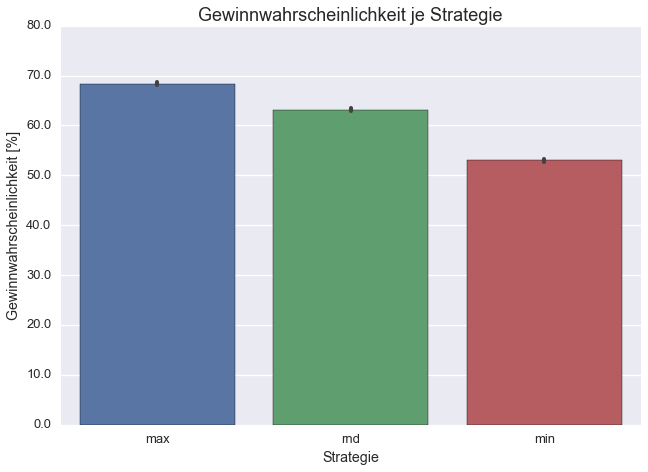

In [26]:
# Größe der Graphiken
sns.set_context("talk")
ax = sns.barplot(x="strategie", y="gewonnen", data=df, order=['max', 'rnd', 'min'])
sns.set(font_scale=1.5)
sns.plt.title('Gewinnwahrscheinlichkeit je Strategie')
sns.set(font_scale=1)
sns.axlabel('Strategie', 'Gewinnwahrscheinlichkeit [%]')
sns.plt.yticks(ax.get_yticks(), ax.get_yticks()*100)
# Speichern der Graphik als svg File, um eine skalierbare Grapik im Blog zur Verfügung zu haben
sns.plt.savefig('01_gewinnwahrscheinlichkeit.svg')

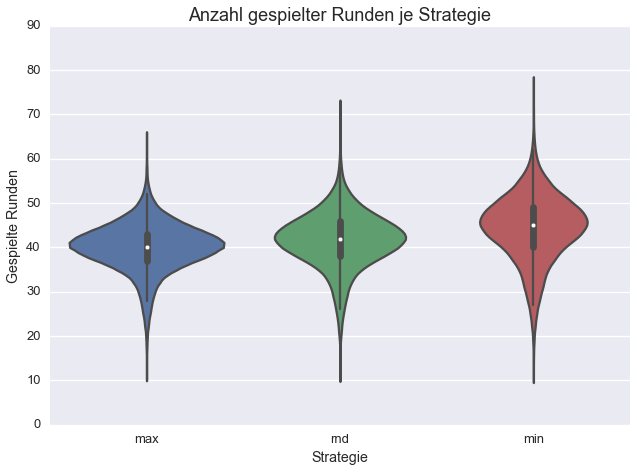

In [27]:
sns.set_context("talk")
sns.violinplot(x='strategie', y='gespielte_runden', data=df, order=['max', 'rnd', 'min'])
sns.set(font_scale=1.5)
sns.plt.title('Anzahl gespielter Runden je Strategie')
sns.set(font_scale=1)
sns.axlabel('Strategie', 'Gespielte Runden')
sns.plt.savefig('02_gespielte_runden.svg')

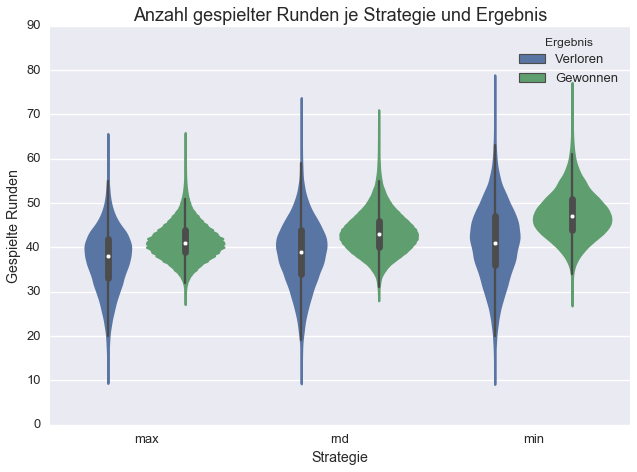

In [28]:
sns.set_context("talk")
sns.violinplot(x='strategie', y='gespielte_runden', hue='Ergebnis', data=df, order=['max', 'rnd', 'min'])
sns.set(font_scale=1.5)
sns.plt.title('Anzahl gespielter Runden je Strategie und Ergebnis')
sns.set(font_scale=1)
sns.axlabel('Strategie', 'Gespielte Runden')
sns.plt.savefig('03_gespielte_runden_je_ergebnis.svg')

Um das Ergebnis noch etwas detailierter betrachten zu können, definiere ich noch eine Spalte `punkte`. 
- Im Fall, dass gewonnen wurde, ist diese die Anzahl der noch nicht befüllten Rabenteile, sprich zwischen 9 (noch kein Rabenteil im Spiel) und 1 (8 Rabenteile im Spiel, noch 1 Rabenfeld frei). 
- Im Fall, dass verloren wurde, wird die negative Anzahl der Früchte, die noch auf den Bäumen sind, angegeben, also zB. -5, falls noch 5 Früchte nicht geerntet wurden.

Insgesamt ist `punkte` also eine Zahl zwischen -40 (wenn 9 mal hintereinander Rabe gewürfelt würde) und +9, wobei das Ergebnis des Spiels ums besser für die Spieler ist, je größer die Zahl ist. Zusätzlich erzeuge ich einen neuen Dataframe, der pro Strategie angebiet, wie häufig diese Endpunkte (in Prozent) auftreten.

In [29]:
df['punkte'] = 9 - df.raben_teile - df.fruechte

dfg = df.groupby(['punkte', 'strategie'])['punkte'].count().unstack('strategie')
dfg = dfg / dfg.sum() * 100
dfg.iloc[[0,1,2,3,4,-3,-2,-1],:]

strategie,max,min,rnd
punkte,,,
-38,0.001,0.001,0.002
-37,0.001,NaN,NaN
-36,0.001,0.003,NaN
-35,NaN,0.005,0.002
-34,0.004,0.002,0.005
7,2.759,1.288,2.145
8,0.881,0.388,0.677
9,0.173,0.065,0.124


Mit `seaborn` kann man gut Farbpaletten angeben. Hier erzeuge ich eine, die von tiefrot (der Rabe gewinnt mit großem Vorsprung) über hellrot (der Rabe gewinnt knapp) zu hellgrün (die Spieler gewinnen knapp) zu dunkelgrün (die Spieler gewinnen klar) reicht.

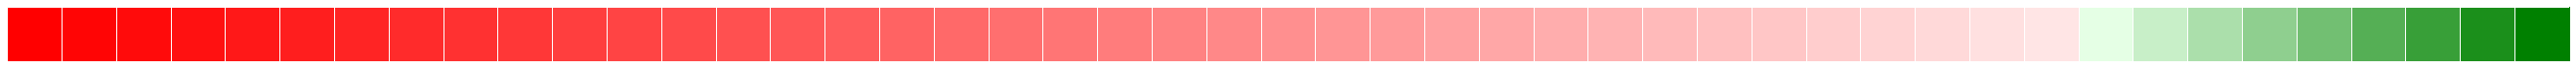

In [30]:
anzahl_punkte_gewonnen = sum(df.punkte.unique() > 0)
anzahl_punkte_verloren = sum(df.punkte.unique() < 0)

pal = sns.light_palette("red", n_colors=anzahl_punkte_verloren, reverse=True) + \
      sns.light_palette("green", n_colors=anzahl_punkte_gewonnen)
sns.palplot(pal)

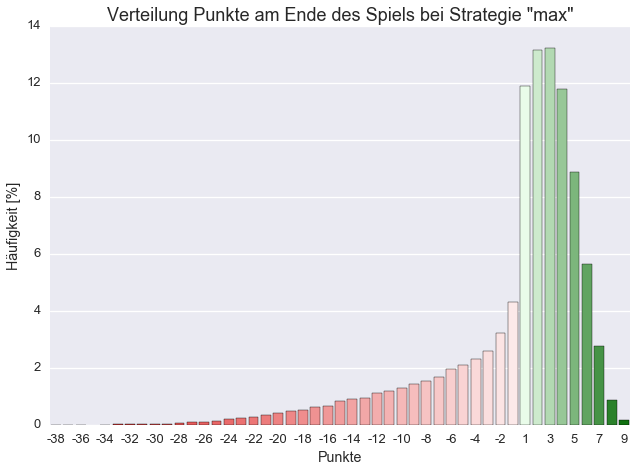

In [31]:
sns.set_context("talk")
plot = sns.barplot(dfg.index, y = dfg['max'], palette=pal)
for label in plot.get_xticklabels()[1::2]:
   label.set_visible(False)
sns.set(font_scale=1.5)
sns.plt.title('Verteilung Punkte am Ende des Spiels bei Strategie "max"')
sns.set(font_scale=1)
sns.axlabel('Punkte', 'Häufigkeit [%]')
sns.plt.savefig('04_verteilung_punkte_strategie_max.svg')

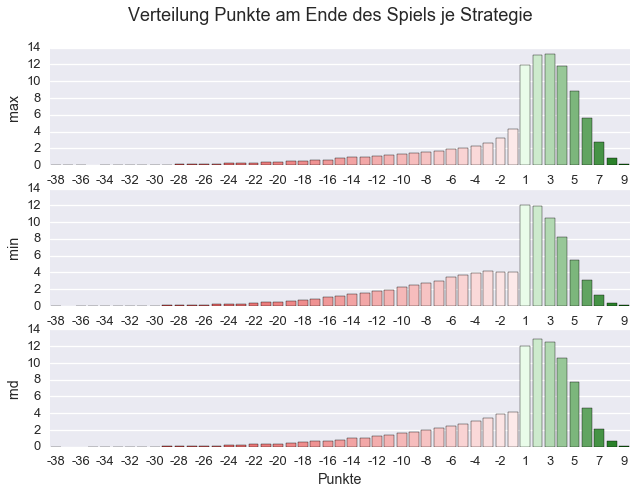

In [32]:
sns.set_context("talk")
fig, axes = sns.plt.subplots(3, 1)
for nr, strategie in enumerate(dfg.columns):
    plot = sns.barplot(dfg.index, y = dfg[strategie], palette=pal, ax=axes[nr], label = strategie)
    #axes[nr].set_title(strategie)
    axes[nr].set_ylabel(strategie)
    axes[nr].set_xlabel('Punkte')
    for label in plot.get_xticklabels()[1::2]:
        label.set_visible(False)
fig.suptitle('Verteilung Punkte am Ende des Spiels je Strategie', fontsize=18)
sns.plt.savefig('05_verteilung_punkte_je_strategie.svg')